In [1]:
import os
import os.path as osp
import time
import pathlib
import tarfile
import numpy as np
import tensorflow as tf
import horovod.tensorflow as hvd
import sys
import multiprocessing

import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append('..')

from awsdet.utils.misc import Config, mkdir_or_exist
from awsdet.utils.runner import init_dist, master_only, get_dist_info, get_barrier
from awsdet.utils.keras import freeze_model_layers

from awsdet import __version__
from awsdet.apis import (get_root_logger, set_random_seed, train_detector,)
from awsdet.datasets import build_dataset, build_dataloader
from awsdet.models import build_detector
from awsdet.utils import visualize

hvd.init()
gpus = tf.config.experimental.list_physical_devices('GPU')

In [2]:
##### TENSORFLOW RUNTIME OPTIONS #####

# tf.config.experimental_run_functions_eagerly(True)
os.environ['TF_CUDNN_USE_AUTOTUNE']= str(0)
os.environ['TF_DETERMINISTIC_OPS'] = str(1)
os.environ['PYTHONHASHSEED']=str(17)
os.environ['HOROVOD_FUSION_THRESHOLD']=str(0)

# init distributed env first
init_dist()

# avoid large pool of Eigen threads
tf.config.threading.set_intra_op_parallelism_threads(multiprocessing.cpu_count()//hvd.size())
tf.config.threading.set_inter_op_parallelism_threads(max(2, 40 // get_dist_info()[2]))
# reduce TF warning verbosity
os.environ['TF_CPP_MIN_LOG_LEVEL'] = str(2)
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [3]:
config = '../configs/mask_rcnn/EC2/mask_rcnn_r50_fpn_1x_coco_exp.py'
cfg = Config.fromfile(config)

In [4]:
model = build_detector(cfg.model,
                           train_cfg=cfg.train_cfg,
                           test_cfg=cfg.test_cfg)

In [5]:
padded_img_side = max(cfg.data.train['scale'])
img = tf.random.uniform(shape=[padded_img_side, padded_img_side, 3], dtype=tf.float32)
img_meta = tf.constant(
    [465., 640., 3., 800., 1101., 3., 
     float(padded_img_side), float(padded_img_side), 3., 1.7204301, 0.],
    dtype=tf.float32)

In [6]:
_ = model((tf.expand_dims(img, axis=0), tf.expand_dims(img_meta, axis=0)),
              training=False)

In [7]:
weights_path = '/workspace/shared_workspace/data/models/resnet50/'
if osp.splitext(weights_path)[1] == '.h5': # older keras format from Keras model zoo
    model.layers[0].layers[0].load_weights(weights_path, by_name=True, skip_mismatch=True)
else: # SavedModel format assumed - extract weights
    backbone_model = tf.keras.models.load_model(weights_path)
    # load weights if layers match
    for layer_idx, layer in enumerate(backbone_model.layers):
        if layer_idx < len(model.layers[0].layers[0].layers):
            model.layers[0].layers[0].layers[layer_idx].set_weights(layer.get_weights())
            print('Loaded weights for:', layer.name)
    del backbone_model

Loaded weights for: input_1
Loaded weights for: conv1_pad
Loaded weights for: conv1_conv
Loaded weights for: conv1_bn
Loaded weights for: conv1_relu
Loaded weights for: pool1_pool
Loaded weights for: conv2_block1_1_conv
Loaded weights for: conv2_block1_1_bn
Loaded weights for: conv2_block1_1_relu
Loaded weights for: conv2_block1_2_conv
Loaded weights for: conv2_block1_2_bn
Loaded weights for: conv2_block1_2_relu
Loaded weights for: conv2_block1_0_conv
Loaded weights for: conv2_block1_3_conv
Loaded weights for: conv2_block1_0_bn
Loaded weights for: conv2_block1_3_bn
Loaded weights for: conv2_block1_add
Loaded weights for: conv2_block1_out
Loaded weights for: conv2_block2_1_conv
Loaded weights for: conv2_block2_1_bn
Loaded weights for: conv2_block2_1_relu
Loaded weights for: conv2_block2_2_conv
Loaded weights for: conv2_block2_2_bn
Loaded weights for: conv2_block2_2_relu
Loaded weights for: conv2_block2_3_conv
Loaded weights for: conv2_block2_3_bn
Loaded weights for: conv2_block2_add
Loa

In [8]:
# load full model
model.load_weights('/workspace/shared_workspace/data/models/011/mask_rcnn')

In [ ]:
train_dataset = build_dataset(cfg.data.train)
val_dataset = build_dataset(cfg.data.val)

loading annotations into memory...


In [ ]:
train_tdf, train_count = build_dataloader(train_dataset, imgs_per_gpu=4)
val_tdf, val_count = build_dataloader(val_dataset, imgs_per_gpu=1)

In [ ]:
train_tdf_iter = iter(train_tdf)
val_tdf_iter = iter(val_tdf)

In [ ]:
imgs, img_metas, gt_boxes, gt_class_ids, gt_masks = next(train_tdf_iter)

In [ ]:
training=True
C2, C3, C4, C5 = model.backbone(imgs, training=training)
P2, P3, P4, P5, P6 = model.neck([C2, C3, C4, C5], training=training)
rpn_feature_maps = [P2, P3, P4, P5, P6]
rcnn_feature_maps = [P2, P3, P4, P5]
rpn_class_logits, rpn_probs, rpn_deltas \
    = model.rpn_head(rpn_feature_maps, training=training)
proposals_list = model.rpn_head.get_proposals(
            rpn_probs, rpn_deltas, img_metas, training=training)
if training:
    rois_list, rcnn_target_matchs, rcnn_target_deltas, \
    inside_weights, outside_weights, fg_assignments = \
    model.bbox_target.build_targets(proposals_list, gt_boxes, gt_class_ids, img_metas)
else:
    rois_list = proposals_list
pooled_regions_list = model.bbox_roi_extractor(
    (rois_list, rcnn_feature_maps, img_metas), training=training)
rcnn_class_logits, rcnn_probs, rcnn_deltas = \
    model.bbox_head(pooled_regions_list, training=training)
if training:
    mask_pooled_regions_list = model.mask_roi_extractor(
            (rois_list, rcnn_feature_maps, img_metas), training=training)
    rcnn_masks = model.mask_head(mask_pooled_regions_list, training=training)
    rcnn_mask_loss = model.mask_head.loss(rcnn_masks, fg_assignments, rcnn_target_matchs, 
                                                 rois_list, gt_masks, img_metas)
    rpn_inputs = (rpn_class_logits, rpn_deltas, gt_boxes, gt_class_ids, img_metas)
    rpn_class_loss, rpn_bbox_loss = model.rpn_head.loss(*rpn_inputs)
    rcnn_inputs = (rcnn_class_logits, rcnn_deltas, rcnn_target_matchs,
                rcnn_target_deltas, inside_weights, outside_weights) 
    rcnn_class_loss, rcnn_bbox_loss = model.bbox_head.loss(rcnn_inputs)
    losses_dict = {
                'rpn_class_loss': rpn_class_loss,
                'rpn_bbox_loss': rpn_bbox_loss,
                'rcnn_class_loss': rcnn_class_loss,
                'rcnn_bbox_loss': rcnn_bbox_loss,
                'mask_loss': rcnn_mask_loss
            }
else:
    detections_dict = {}
    detections_list = model.bbox_head.get_bboxes(rcnn_probs, rcnn_deltas, rois_list, img_metas)
    detections_dict = {
            'bboxes': detections_list[0][0],
            'labels': detections_list[0][1],
            'scores': detections_list[0][2]
    }
    mask_boxes = [tf.round(detections_dict['bboxes'])]
    mask_pooled_regions_list = model.mask_roi_extractor(
                                (mask_boxes, 
                                 rcnn_feature_maps, img_metas), training=training)
    rcnn_masks = model.mask_head(mask_pooled_regions_list)[0]
    rcnn_masks = model.mask_head.gather_mask_predictions(rcnn_masks, detections_dict['labels'])
    detections_dict['masks'] = model.mask_head.mold_masks(rcnn_masks, mask_boxes[0], img_metas[0])

In [ ]:
losses_dict

In [408]:
batch_size = tf.shape(img_metas)[0]
num_rois = tf.shape(rois_list[0])[0]
fg_assignments = tf.cast(tf.reshape(fg_assignments, [batch_size, num_rois]), tf.int32)
rcnn_target_matchs = tf.reshape(rcnn_target_matchs, [batch_size, num_rois])
gt_masks = tf.expand_dims(gt_masks, [-1])
loss = 0.
valid_losses = 0

In [432]:
masks_pred = model.mask_head.gather_mask_predictions(rcnn_masks[0], rcnn_target_matchs[0])
masks_true = model.mask_head.crop_masks(rois_list[0], fg_assignments[0], gt_masks[0], img_metas[0])
masks_true = tf.boolean_mask(masks_true, rcnn_target_matchs[0]!=0)
mask_count = tf.shape(masks_pred)[0]
loss = tf.math.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=masks_true, 
                                                                logits=masks_pred))



In [436]:
tf.math.multiply(*model.mask_head.crop_size)

<tf.Tensor: shape=(), dtype=int32, numpy=73696>

In [280]:
def get_original_image(img, cfg, img_metas):
    img = img[0]
    img = img[:int(img_metas[0][3]), :int(img_metas[0][4]), :]
    img = (img * cfg.data.train.std + cfg.data.train.mean)
    return img.numpy()

In [281]:
pred_img = visualize.make_image(get_original_image(imgs, cfg, img_metas), 
                     detections_dict['bboxes'][:10].numpy(),
                     detections_dict['labels'][:10].numpy(),
                     visualize.coco_categories)

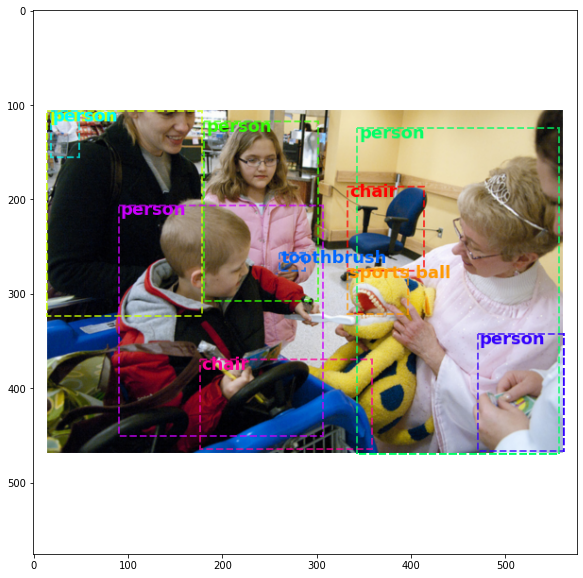

In [282]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(pred_img)

In [283]:
def get_mask(mask, img_metas):
    mask = mask[:int(img_metas[0][3]), :int(img_metas[0][4])]
    mask = tf.squeeze(mask)
    return mask.numpy()

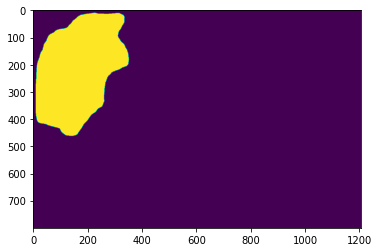

In [284]:
plt.imshow(get_mask(detections_dict['masks'][1], img_metas))

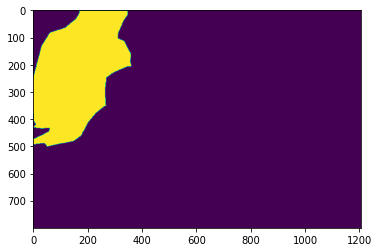

In [309]:
plt.imshow(get_mask(gt_masks[0][5], img_metas))

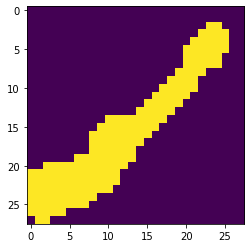

In [298]:
plt.imshow(tf.squeeze(tf.cast(rcnn_masks[6]>0, tf.int32)))

In [322]:
mask_rois = tf.boolean_mask(rois_list[0], fg_assignments==5)/1333

In [336]:
cropped_masks = tf.image.crop_and_resize(tf.expand_dims(tf.squeeze(gt_masks), axis=[-1]),
                             rois_list[0]/1333,
                             tf.cast(fg_assignments, tf.int32),
                             (28, 28),
                             method='nearest')

In [338]:
subset_mask = tf.boolean_mask(cropped_masks, fg_assignments==5)

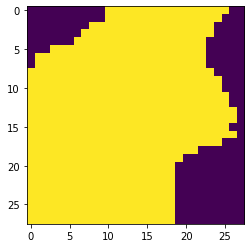

In [380]:
plt.imshow(tf.squeeze(subset_mask[7]))

In [355]:
subset_pred = tf.boolean_mask(rcnn_masks[0], fg_assignments==5)
subset_cats = tf.boolean_mask(rcnn_target_matchs, fg_assignments==5)

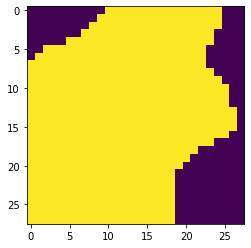

In [381]:
plt.imshow(tf.cast(tf.squeeze(subset_pred[7][0])>0, tf.int32))